In [18]:
import os
from os import listdir
from os.path import isfile, join
dir_files = [i for i in os.listdir(os.getcwd() + '/data') if os.path.isfile(join(os.getcwd() + '/data', i))]
dir_files

['1year.arff', '2year.arff', '3year.arff', '4year.arff', '5year.arff']

In [19]:
from scipy.io import arff
import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

In [20]:
#combine all the files
data_dict = {}
full_df = pd.DataFrame()

records = 0

for f in dir_files:
    temp_data = arff.loadarff(os.getcwd() + '/data/' +f)
    temp_df = pd.DataFrame(temp_data[0])
    print(temp_df.shape)
    data_dict.update({f:temp_df})
    full_df = pd.concat([full_df, temp_df])
    records += temp_df.shape[0]

print(records)

(7027, 65)
(10173, 65)
(10503, 65)
(9792, 65)
(5910, 65)
43405


In [21]:
missing_vals = full_df.isna().sum()
missing_vals = pd.DataFrame(missing_vals,columns=['missing'])
missing_vals = missing_vals.sort_values(by = ['missing'],ascending=False)
missing_vals.reset_index()

,index,missing
0,Attr37,18984
1,Attr21,5854
2,Attr27,2764
3,Attr60,2152
4,Attr45,2147
...,...,...
60,Attr10,8
61,Attr57,7
62,Attr59,7
63,Attr55,1


Text(0, 0.5, 'Attributes')

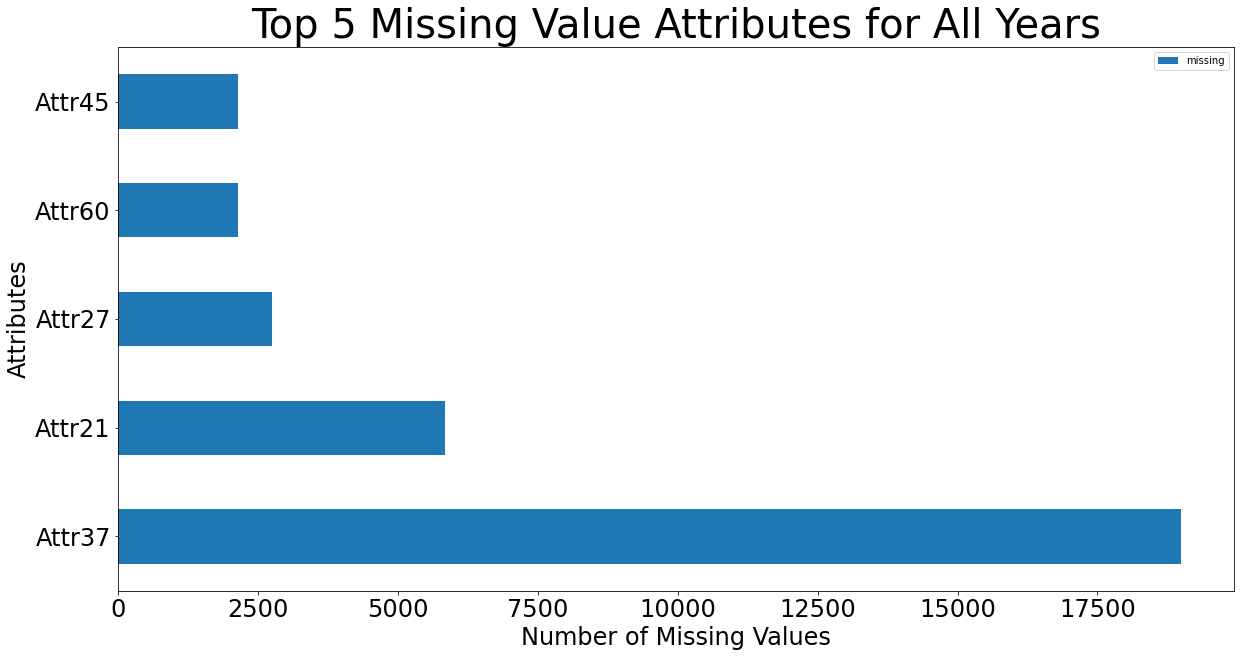

In [22]:
top_five_missing  = missing_vals.head(5)
ax = top_five_missing.plot.barh(title = 'Top 5 Missing Value Attributes for All Years'
,figsize = (20,10),fontsize=24)
ax.title.set_size(40)
ax.set_xlabel('Number of Missing Values',fontsize = 24)
ax.set_ylabel('Attributes',fontsize = 24)


In [23]:
full_df['class'].value_counts()

b'0'    41314
b'1'     2091
Name: class, dtype: int64

In [24]:
41314/43405

0.9518258265176823

In [25]:
classes = []
uniqueClass = full_df['class'].unique()
classes.append(uniqueClass[0])
classes.append(uniqueClass[1])
classes

[b'0', b'1']

In [26]:
class_dict = {}

for index, i in enumerate(classes):
    class_dict.update({i:index})

class_dict

{b'0': 0, b'1': 1}

In [27]:
full_df['class'] = full_df['class'].map(class_dict)

# Random Forest base model no cv to get feature importance

In [28]:
X = full_df.loc[:, full_df.columns != 'class'].values
y = full_df['class'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 58)

In [29]:
from sklearn.impute import SimpleImputer

imp_mean = SimpleImputer(missing_values = np.nan, strategy = 'mean')
imp_mean.fit(X_train)

X_train = imp_mean.transform(X_train)
X_test = imp_mean.transform(X_test)
cols = full_df.columns.values.tolist()
cols.remove('class')
X_train = pd.DataFrame(X_train, columns=cols)
X_test = pd.DataFrame(X_test, columns=cols)

In [30]:
rf_clf1 = RandomForestClassifier(random_state = 58)
rf_clf1.fit(X_train, y_train)
rf_clf1.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 58,
 'verbose': 0,
 'warm_start': False}

In [31]:
y_hat_rf_test1 = rf_clf1.predict(X_test)
print("Confusion Matrix \n",confusion_matrix(y_test, y_hat_rf_test1))
print("\n Classification Report \n",classification_report(y_test, y_hat_rf_test1, digits=6))

Confusion Matrix 
 [[10290    43]
 [  342   177]]

 Classification Report 
               precision    recall  f1-score   support

           0   0.967833  0.995839  0.981636     10333
           1   0.804545  0.341040  0.479026       519

    accuracy                       0.964523     10852
   macro avg   0.886189  0.668440  0.730331     10852
weighted avg   0.960024  0.964523  0.957599     10852



# Feature Importance

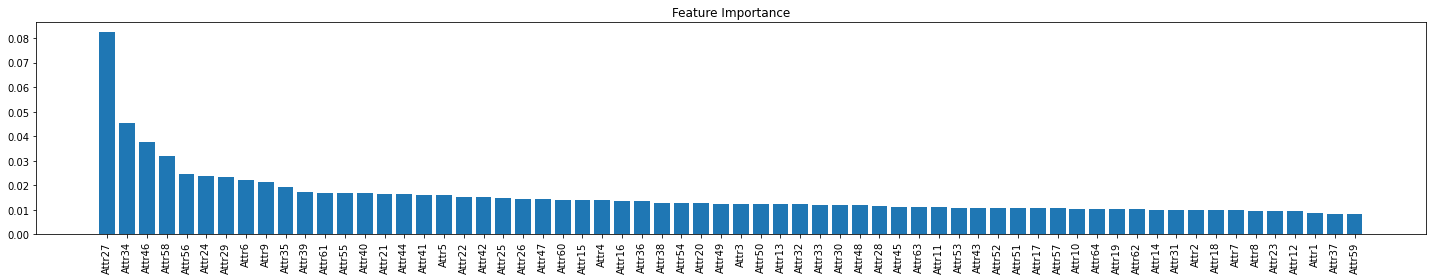

In [46]:
feature_importances = rf_clf1.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]
plt.figure(figsize=(20,4))
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), feature_importances[sorted_indices], align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()

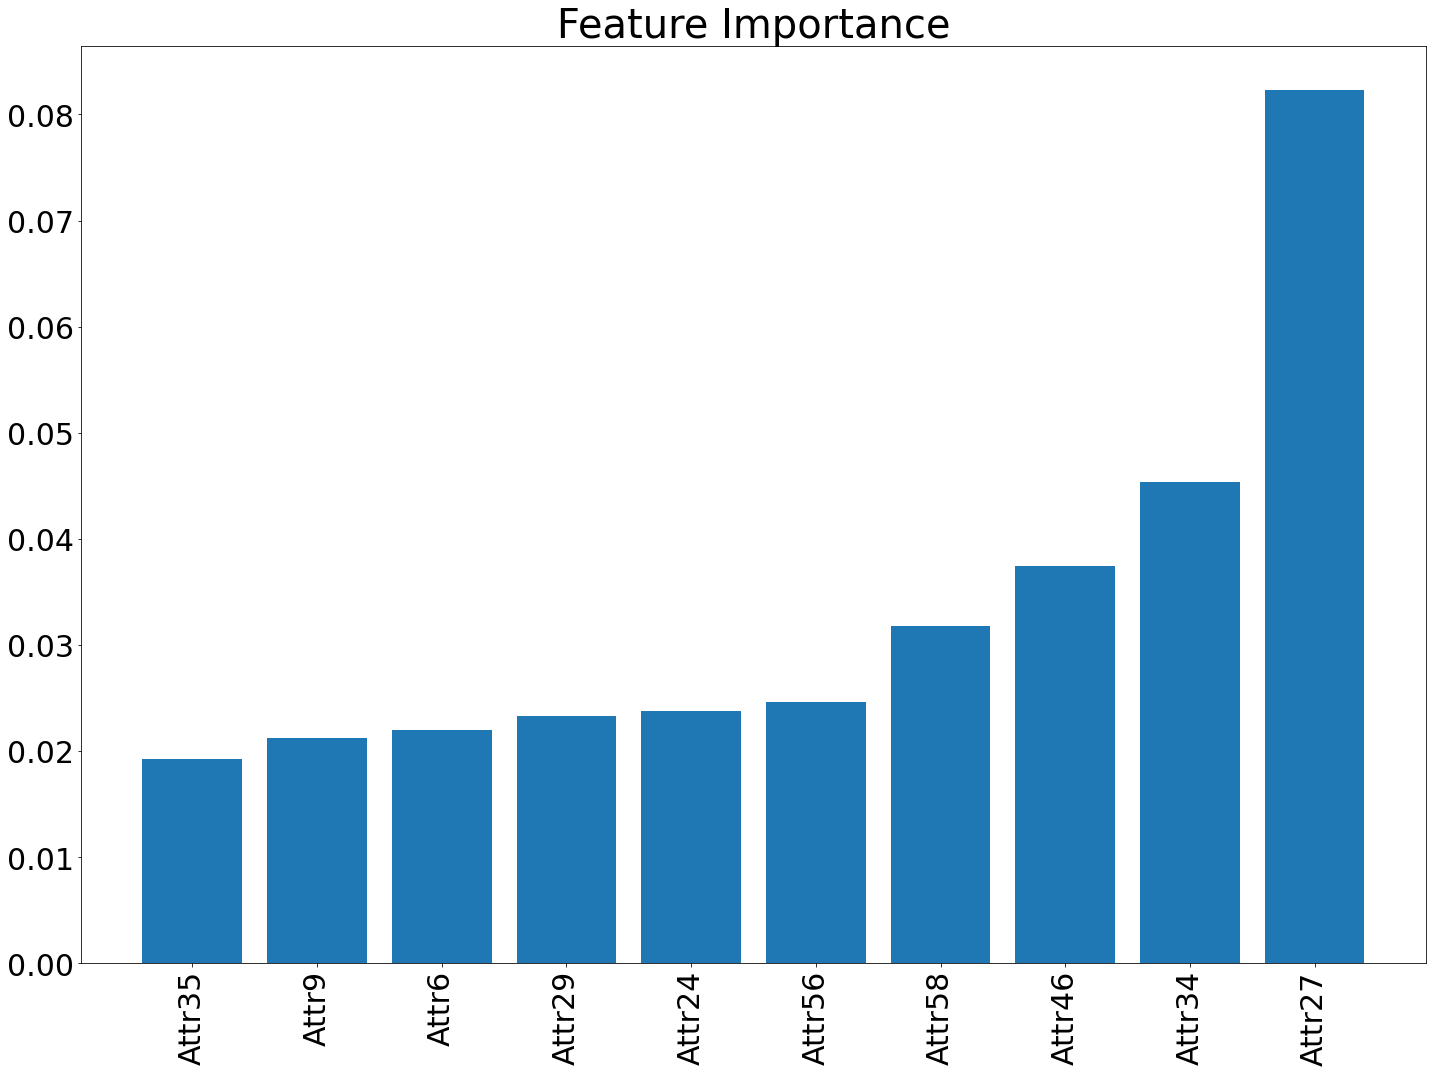

In [67]:
feature_importances = rf_clf1.feature_importances_
sorted_indices = np.argsort(feature_importances)[54:64]
plt.figure(figsize=(20,15))
plt.title('Feature Importance',fontsize = 40)
plt.bar(range(10), feature_importances[sorted_indices], align='center')
plt.xticks(range(10), X_train.columns[sorted_indices], rotation=90,fontsize = 30)
plt.yticks(fontsize = 30)
plt.tight_layout()
plt.show()

In [42]:
sorted_indices

array([26, 33, 45, 57, 55, 23, 28,  5,  8, 34, 38, 60, 54, 39, 20, 43, 40,
        4, 21, 41, 24, 25, 46, 59, 14,  3, 15, 35, 37, 53, 19, 48,  2, 49,
       12, 31, 32, 29, 47, 27, 44, 62, 10, 52, 42, 51, 50, 16, 56,  9, 63,
       18, 61, 13, 30,  1, 17,  6,  7, 22, 11,  0, 36, 58], dtype=int64)

In [34]:
feature_importances_short = feature_importances[:10]
print(feature_importances_short)

[0.00882564 0.00999294 0.01248991 0.01397204 0.01617684 0.02202404
 0.00985148 0.00961131 0.02120331 0.01048032]


# Random Forest Gridsearch


In [ ]:
rf_clf2 = RandomForestClassifier(random_state=58)
param_grid = { 
    'n_estimators': [25,50,100,200],
    'max_features': ['auto', 'sqrt'],
    'max_depth' : [10,15,20],
    'criterion' :['gini', 'entropy']
}
CV_rfc = GridSearchCV(estimator=rf_clf2, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=58),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 15, 20],
                         'max_features': ['auto', 'sqrt'],
                         'n_estimators': [25, 50, 100, 200]},
             verbose=1)

In [ ]:
best_model = CV_rfc.best_params_
CV_rfc.best_params_

{'criterion': 'gini',
 'max_depth': 15,
 'max_features': 'auto',
 'n_estimators': 200}

In [ ]:
rf_clf=RandomForestClassifier(best_model)
rf_clf3.fit(X_train, y_train)
y_hat_rf_train4 = rf_clf3.predict(X_test)
print("Confusion Matrix \n",confusion_matrix(y_train, y_hat_rf_train4))
print("\n Classification Report \n",classification_report(y_train, y_hat_rf_train4, digits=6))

Confusion Matrix 
 [[30981     0]
 [    0  1572]]

 Classification Report 
               precision    recall  f1-score   support

           0   1.000000  1.000000  1.000000     30981
           1   1.000000  1.000000  1.000000      1572

    accuracy                       1.000000     32553
   macro avg   1.000000  1.000000  1.000000     32553
weighted avg   1.000000  1.000000  1.000000     32553

